# This notebook will show how to use the ROSE framework to run two active learning algorithms in **asynchronously** (in parallel) and select the best one based on a metric.

In [1]:
import os
import sys
import asyncio

from rose.learner import AlgorithmSelector
from rose.metrics import MEAN_SQUARED_ERROR_MSE

from radical.flow import WorkflowEngine, RadicalExecutionBackend, Task

Let us prepare our execution engine using a local resource (user computer). We will ask for 30 minutes as this example will run fast.

In [2]:
%env FLOW_JUPYTER_ASYNC=TRUE

engine = RadicalExecutionBackend({'resource': 'local.localhost'})

algo_selector = AlgorithmSelector(engine)
code_path = f'{sys.executable} {os.getcwd()}'

env: FLOW_JUPYTER_ASYNC=TRUE
RadicalPilot execution backend started successfully



We will define our active learning workflow components like our previous tutorials. Please note that, unlike the previous tutorials, we defined **two** active learning tasks (`algo1` and `algo2`). ROSE will select the best based on the number of iterations and the final selected metric.

In [4]:
# Define and register the simulation task
@algo_selector.simulation_task
async def simulation(*args):
    return Task(executable=f'{code_path}/sim.py')

# Define and register the training task
@algo_selector.training_task
async def training(*args):
    return Task(executable=f'{code_path}/train.py')

# Define and register Multiple AL tasks
@algo_selector.active_learn_task(name='algo_1')
async def active_learn_1(*args):
    return Task(executable=f'{code_path}/active_1.py')

@algo_selector.active_learn_task(name='algo_2')
async def active_learn_2(*args):
    return Task(executable=f'{code_path}/active_2.py')

# Defining the stop criterion with a metric (MSE in this case)
@algo_selector.as_stop_criterion(metric_name=MEAN_SQUARED_ERROR_MSE, threshold=0.01)
async def check_mse(*args):
    return Task(executable=f'{code_path}/check_mse.py')

Let us invoke our workflow and instruct ROSE to select one of both algorithms. Note that since we are running from within a Jupyter Notebook, then we only need to do `await run_and_shutdown()` and not `asyncio.run(run_and_shutdown())` as we are already inside a `running loop`

In [5]:
async def run_and_shutdown():
    # Now, call the tasks and teach
    simul = simulation()
    train = training()
    active_1 = active_learn_1()
    active_2 = active_learn_2()
    stop_cond = check_mse()
    
    # Start the teaching process
    await algo_selector.teach_and_select(max_iter=4)
    engine.shutdown()

await run_and_shutdown()

[Pipeline: active_learn_1] Starting Iteration-0
[Pipeline: active_learn_2] Starting Iteration-0
stop criterion metric: mean_squared_error_mse is not met yet (0.03).
stop criterion metric: mean_squared_error_mse is not met yet (0.03).
[Pipeline: active_learn_1] Starting Iteration-1
[Pipeline: active_learn_2] Starting Iteration-1
stop criterion metric: mean_squared_error_mse is not met yet (0.03).
stop criterion metric: mean_squared_error_mse is not met yet (0.03).
[Pipeline: active_learn_2] Starting Iteration-2
[Pipeline: active_learn_1] Starting Iteration-2
stop criterion metric: mean_squared_error_mse is not met yet (0.01).
stop criterion metric: mean_squared_error_mse is not met yet (0.01).
[Pipeline: active_learn_2] Starting Iteration-3
[Pipeline: active_learn_1] Starting Iteration-3
stop criterion metric: mean_squared_error_mse is not met yet (0.01).
stop criterion metric: mean_squared_error_mse is met with value of: 0.0. Breaking the active learning loop
Best algorithm is 'algo_2'

Once the execution is done, we can plot the results and of each algorithm as follows:

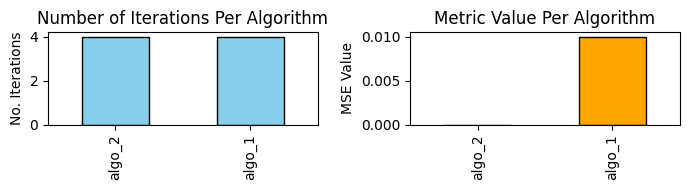

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
results = algo_selector.algorithm_results

# Convert to DataFrame
df = pd.DataFrame(results).T  # Transpose to have algorithms as index

# Create a figure with two subplots: one for iterations and one for last_result
fig, ax = plt.subplots(1, 2, figsize=(7, 2))

# Plot iterations
df['iterations'].plot(kind='bar', ax=ax[0], color='skyblue', title='Number of Iterations Per Algorithm', edgecolor='black')
ax[0].set_ylabel('No. Iterations')

# Plot last_result
df['last_result'].plot(kind='bar', ax=ax[1], color='orange', title='Metric Value Per Algorithm', edgecolor='black')
ax[1].set_ylabel('MSE Value')

# Show plot
plt.tight_layout()
plt.show()

### What do the above plots tell us?

The **Algorithm Selector** evaluates two different active learning algorithms, `algo_1` and `algo_2`, using the same input data. The left plot shows the number of iterations each algorithm required to reach convergence, while the right plot compares their Mean Squared Error (MSE) performance.

From the results, we can observe that algo_2 required more iterations to converge compared to algo_1, indicating a potentially longer training time. However, when analyzing the MSE values, algo_2 achieved a lower error, suggesting better predictive performance. This trade-off between convergence speed and accuracy is an important consideration when selecting an active learning strategy. In practical applications, users may prioritize either efficiency (fewer iterations) or model accuracy (lower MSE) depending on their specific requirements.

More importantly is that all of the work above was done in an **embarrassingly parallel** approach, and **effortlessly**.